# Imports and define expectation func

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_expectation_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG

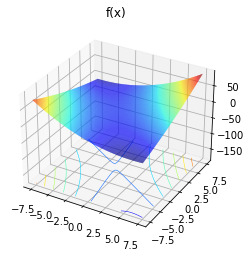

In [3]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Lumpy High Dimension Flow Target Distribution

In [ ]:
torch.set_default_dtype(torch.float64)

In [ ]:
epochs = int(1e6)
batch_size = int(1e2)
dim = 3
n_samples_estimation = int(1e6)
KPI_n_samples = int(1e4)
lr = 5e-6
optimizer = "Adamax"
flow_type = "IAF" #"RealNVP"
n_flow_steps = 3  # 5
prior_scaling_factor = 5.0

In [ ]:
torch.manual_seed(0)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
print(target.covs.device)
true_expectation = MC_estimate_true_expectation(target, expectation_function, n_samples_estimation)
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, n_samples_estimation)) # print twice to make sure estimates are resonably close
target.to("cuda")
print(target.covs.device)

# DReG, alpha=2

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=prior_scaling_factor, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG",
                                   lr=lr, optimizer=optimizer)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
samples_fig_before = plot_samples(tester, n_samples=batch_size) # this just looks at 2 dimensions

In [ ]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples,
                       clip_grad=True, max_grad_norm=0.5)

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

In [ ]:
hist_plot = plot_history(history)

# KL

In [ ]:
torch.manual_seed(1)
learnt_sampler_kl = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester_kl = LearntDistributionManager(target, learnt_sampler_kl, VanillaImportanceSampling, loss_type="kl", lr=1e-3)
expectation_before_kl, info_before_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
samples_fig_before = plot_samples(tester_kl)

In [ ]:
history_kl = tester_kl.train(epochs, batch_size=batch_size,)

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester_kl)

In [ ]:
plot_divergences(history_kl)

In [ ]:
plot_sampling_info(history_kl)

In [ ]:
hist_plot = plot_history(history_kl)